<ipython-input-6-28e415934a07>:143: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
<ipython-input-6-28e415934a07>:37: RuntimeWarning: Degrees of freedom <= 0 for slice
  rho = np.sum([np.cov(np.sqrt(T) * sample_cov[i, j], np.sqrt(T) * shrinkage_target[i, j])[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-6-28e415934a07>:37: RuntimeWarning: Degrees of freedom <= 0 for slice
  rho = np.sum([np.cov(np.sqrt(T) * sample_cov[i, j], np.sqrt(T) * shrinkage_target[i, j])[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/fun

Running backtest with transaction costs and Ledoit-Wolf shrinkage covariance matrix...


<ipython-input-6-28e415934a07>:37: RuntimeWarning: Degrees of freedom <= 0 for slice
  rho = np.sum([np.cov(np.sqrt(T) * sample_cov[i, j], np.sqrt(T) * shrinkage_target[i, j])[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-6-28e415934a07>:37: RuntimeWarning: Degrees of freedom <= 0 for slice
  rho = np.sum([np.cov(np.sqrt(T) * sample_cov[i, j], np.sqrt(T) * shrinkage_target[i, j])[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipyth


Backtest Results with Transaction Costs and Ledoit-Wolf Shrinkage Covariance Matrix:
Total Return (including initial capital): 3.4022
Profit-only Return: 240.2244%
Annualized Return: 35.22%
Annualized Volatility: 16.55%
Sharpe Ratio: 1.91
Sortino Ratio: 1.84
Max Drawdown: -19.08%
Calmar Ratio: 1.85
Average Shrinkage Delta: 0.5000


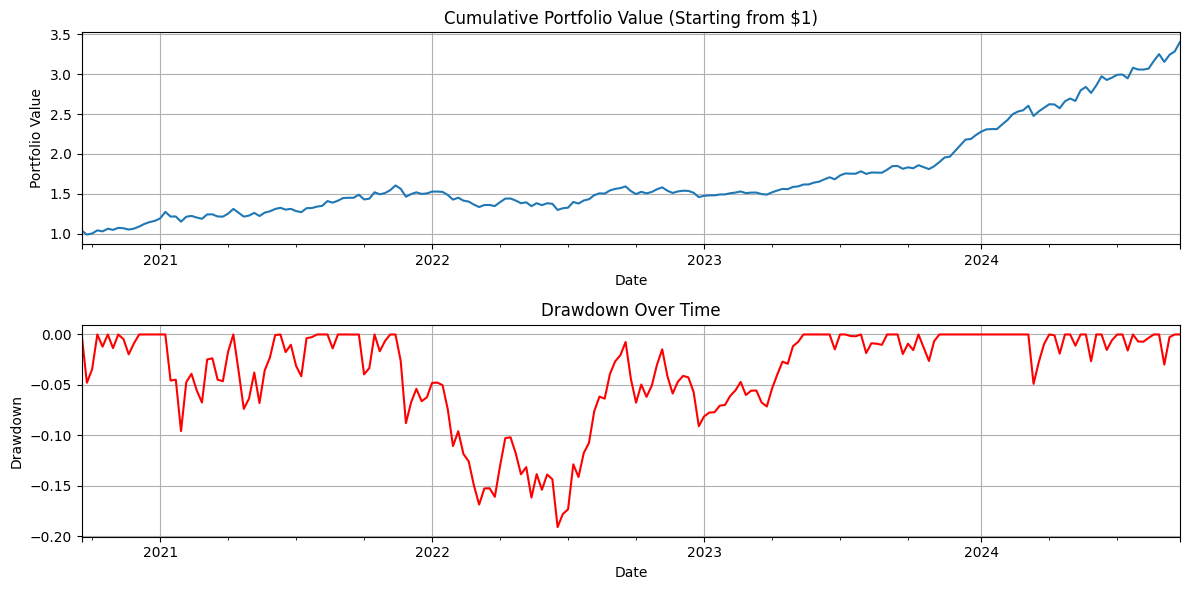


Stock Weightage on 2024-09-29 00:00:00:
TRENT: 0.0748
VEDL: 0.0324
BAJAJAUTO: 0.0996
ADANIGREEN: 0.0000
HAL: 0.0000
BEL: 0.0000
SIEMENS: 0.0435
M&M: 0.0449
ABB: 0.0000
HINDZINC: 0.0000
powergrid: 0.0642
INDIGO: 0.0735
NTPC: 0.0574
ADANIENT.1: 0.0193
BHARTIARTL: 0.1457
COALINDIA: 0.0460
VBL: 0.0625
ONGC: 0.0817
DLF: 0.0365
SUNPHARMA: 0.1178


<ipython-input-6-28e415934a07>:37: RuntimeWarning: Degrees of freedom <= 0 for slice
  rho = np.sum([np.cov(np.sqrt(T) * sample_cov[i, j], np.sqrt(T) * shrinkage_target[i, j])[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns


def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()


def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

# Ledoit-Wolf shrinkage covariance matrix function
def ledoit_wolf_shrinkage(returns):
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)

    # Step 1: Shrinkage target (constant correlation model)
    mean_variance = np.mean(np.diag(sample_cov))  # average variance
    mean_corr = (np.sum(np.tril(np.corrcoef(returns, rowvar=False), -1)) / (N * (N - 1) / 2))  # average correlation

    shrinkage_target = np.full((N, N), mean_corr)
    np.fill_diagonal(shrinkage_target, np.diag(sample_cov))  # set diagonal elements to Sii
    shrinkage_target = np.multiply(shrinkage_target, np.outer(np.sqrt(np.diag(sample_cov)), np.sqrt(np.diag(sample_cov))))

    # Step 2: Shrinkage constant delta
    pi = np.sum([np.var(np.sqrt(T) * sample_cov[i, j]) for i in range(N) for j in range(i+1, N)])  # sum of variances
    rho = np.sum([np.cov(np.sqrt(T) * sample_cov[i, j], np.sqrt(T) * shrinkage_target[i, j])[0, 1]
                  for i in range(N) for j in range(i+1, N)])  # sum of covariances
    gamma = np.sum([(sample_cov[i, j] - shrinkage_target[i, j]) ** 2
                    for i in range(N) for j in range(N)])  # sum of squared differences

    if gamma != 0:
        delta = max(0, min(1, (pi - rho) / gamma))  # shrinkage constant delta
    else:
        delta = 1  # If gamma is 0, avoid division by zero and set delta to 1

    # Step 3: Compute the shrunk covariance matrix
    shrunk_cov = delta * shrinkage_target + (1 - delta) * sample_cov

    return shrunk_cov, delta

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))


def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})


    cov_matrix, delta = ledoit_wolf_shrinkage(returns.values)


    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, delta


def get_stock_weightage(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]


    weights, delta = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights, delta


def calculate_transaction_costs(prev_weights, new_weights, transaction_cost=0.001):
    weight_diff = np.abs(np.array(new_weights) - np.array(prev_weights))
    total_transaction_cost = np.sum(weight_diff) * transaction_cost
    return total_transaction_cost


def backtest_strategy(df, transaction_cost=0.001):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    shrinkage_deltas = []

    prev_weights = np.zeros(20)  # Initialize previous weights as zeros
    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage, delta = get_stock_weightage(weekly_returns.iloc[:i], current_date)
            shrinkage_deltas.append(delta)

            top_stocks = list(weightage.keys())
            new_weights = list(weightage.values())

            # Calculate portfolio return for the next week
            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(new_weights)

            # Adjust return by transaction costs
            transaction_costs = calculate_transaction_costs(prev_weights, new_weights, transaction_cost)
            adjusted_return = next_week_return - transaction_costs
            portfolio_returns.append(adjusted_return)
            weightage_history.append((next_week, weightage))

            prev_weights = new_weights  # Update previous weights for the next iteration

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history, shrinkage_deltas


def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown


def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan


def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan


df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest with transaction costs and Ledoit-Wolf shrinkage covariance matrix
print("Running backtest with transaction costs and Ledoit-Wolf shrinkage covariance matrix...")
portfolio_returns, weightage_history, shrinkage_deltas = backtest_strategy(df, transaction_cost=0.001)


cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)


drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)


print("\nBacktest Results with Transaction Costs and Ledoit-Wolf Shrinkage Covariance Matrix:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")
print(f"Average Shrinkage Delta: {np.mean(shrinkage_deltas):.4f}")


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

weekly_returns = calculate_weekly_returns(df)


last_date = weekly_returns.index[-1]
try:
    weightage, delta = get_stock_weightage(weekly_returns, last_date)
    print(f"\nStock Weightage on {last_date}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(e)
